# Trabalho 3 - Classificadores - v1.2

## Código + Relatório

## Código:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from scipy.spatial import distance

In [2]:
#Calcula a função
def sigmoid(x):
    return 1/(1 + np.exp(-1 * x))

#Calcula a derivada da função
def sigmoid_derived(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Rede MLP para Classificação 

In [3]:
class networksMLP():
    
    def __init__(self, input_layer_size=2, hidden_layer_size=4):
        self.w = np.ones((hidden_layer_size, input_layer_size + 1))
        self.m = np.ones((1, hidden_layer_size + 1))
        self.e = {}
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = 1
        self._estimator_type = "classifier"
    
    
    def fit(self, X, y, learning_rate=0.01, epochs=50):
        #Bias
        bias = np.full((X.shape[0], 1), -1)
        X = np.hstack((bias,X))
        
        for i in range(0, epochs):
            self.aux_pred(X)
            self.e = y - self.y_pred
            
            #Treinando a camada de saída
            for j in range(0, X.shape[0]):
                delta_k = self.e[j] * sigmoid_derived(np.sum(self.z * np.transpose(self.m)))
                self.m = self.m + learning_rate * delta_k * self.z
                
                #Treinando a camada oculta
                for wI in range(0, self.w.shape[0]):
                    delta_i = sigmoid_derived(np.sum(X[j] * self.w[wI, :])) * np.sum(delta_k * self.m[0, wI])
                    self.w[wI, :] = self.w[wI, :] + learning_rate * delta_i * X[j]          

                    
    def aux_pred(self, X):
        #Saídas
        sample = 0
        self.z = np.ones((1,self.hidden_layer_size+1))
        self.z[0,0] = -1
        self.y_pred = np.array([])
        
        for x in X:
            this_y_pred = np.array([])
            for i in range(0, self.w.shape[0]):
                u = np.sum(x * self.w[i,:])
                self.z[0,i+1] = sigmoid(u)
                
            for i in range(0, self.m.shape[0]):
                u = np.sum(self.z * self.m)
                this_y_pred = np.append(this_y_pred, sigmoid(u))
            
            if this_y_pred > 0.5:
                this_y_pred = 1
            else: 
                this_y_pred = 0
                
            self.y_pred = np.append(self.y_pred, this_y_pred)
            sample += 1
        
        return self.y_pred
                
        
    def predict(self, X):
        #Bias
        bias = np.full((X.shape[0], 1), -1)
        X = np.hstack((bias, X))
        
        #Saídas
        sample = 0
        self.z = np.ones((1,self.hidden_layer_size+1))
        self.z[0,0] = -1
        self.y_pred = np.array([])
        
        for x in X:
            this_y_pred = np.array([])
            for i in range(0, self.w.shape[0]):
                u = np.sum(x * self.w[i,:])
                self.z[0,i+1] = sigmoid(u)
                
            for i in range(0, self.m.shape[0]):
                u = np.sum(self.z * self.m)
                this_y_pred = np.append(this_y_pred, sigmoid(u))
            
            if this_y_pred > 0.5:
                this_y_pred = 1
            else:
                this_y_pred = 0
            
            self.y_pred = np.append(self.y_pred, this_y_pred)
            sample += 1
        
        return self.y_pred

## KNN 

In [4]:
class knn():
    
    def __init__(self, k=2):
        self._estimator_type = "classifier"
        self.k = k
        pass
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):  
        result = np.array([])
        for x in X:    
            #Calculando os vizinhos mais proximos
            k_nearest_classes = np.full((1,self.k), -1) 
            k_nearest_values = np.full((1,self.k), np.inf)
            
            for x_train_i in range(0, self.X_train.shape[0]):
                distance_ = distance.euclidean(x, self.X_train[x_train_i])
                classe_ = self.y_train[x_train_i]
                
                for k_nearest_i in range(0, self.k):
                    if distance_ < k_nearest_values[0,k_nearest_i] :
                        previous_class = k_nearest_classes[0, k_nearest_i]
                        previous_distance = k_nearest_values[0,k_nearest_i]
                        
                        k_nearest_classes[0,k_nearest_i] = classe_
                        k_nearest_values[0,k_nearest_i] = distance_
                        
                        classe_ = previous_class
                        distance_ = previous_distance          
            
            #Calculando a classe de maior ocorrência
            class_largest = 0
            qtd_largest = 0
            for classe in np.unique(self.y_train):
                class_qtd = np.sum(k_nearest_classes == classe)
                if class_qtd > qtd_largest:
                    qtd_largest = class_qtd
                    class_largest = classe            

            result = np.append(result, class_largest)
            
        return result

## Implementar função k_fold(X, y, k, metodo) 

In [5]:
def k_fold (X, y, k, metodo):
    e = np.array([])
    part = 1/k
    qtd_part = int(X.shape[0] * part)
    
    for i in range(0, k):
        init_part = qtd_part * i
        end_part = qtd_part * (i+1)
        
        X_train = X[init_part:end_part, :]
        y_train = y[init_part:end_part]
        
        X_test = X[:init_part, :]
        X_test = np.vstack((X_test, X[end_part:, :]))
            
        y_test = y[0:init_part]
        y_test = np.append(y_test, y[end_part:])
                
        metodo.fit(X_train, y_train)
        y_pred = metodo.predict(X_test)
        
        e = np.append(e, acuracia(y_test, y_pred))
                      
    return print("Erros: ", e)

## Função Acurácia 

In [6]:
def acuracia(y_true, y_pred):
    count = 0;
    for t, p in zip(y_true, y_pred):
        if t == p:
            count += 1
    return (count / y_true.shape[0])

## Matriz de confusão

In [7]:
def plot_confusion_matrix_(X, y, clf):
    conf = plot_confusion_matrix(clf, X, y)
    conf.ax_.set_title("Matriz de confusão")
    plt.show()

## Gráfico de dispersão

In [8]:
def plot_boundaries(X, y, clf):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

## Carregando e dividindo o conjunto de dados 

In [9]:
#Carregando os dados
data = np.loadtxt("./data1.txt", delimiter=",")

X = data[:,:-1]
y = data[:, -1]

#Normalizando os dados
X = (X - X.min()) / (X.max() - X.min())

# Dividindo e embaralhando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)

## Relatório:

## Rede MLP

### Tamanho da camada oculta = 2

In [10]:
#Acurácia

MLP2 = networksMLP(input_layer_size=2, hidden_layer_size=2)
MLP2.fit(X, y, epochs=60, learning_rate=0.01)
y_pred_MLP2 = MLP2.predict(X)

print('Acurácia: ', acuracia(y, y_pred_MLP2))

Acurácia:  0.9


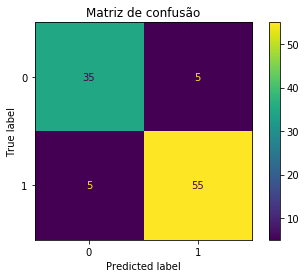

In [11]:
#Matriz de confusão

MLP2.classes_ =  ["0","1"]
plot_confusion_matrix_(X, y, MLP2)

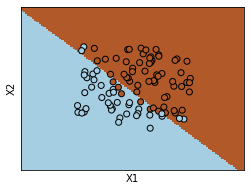

In [12]:
# Gráfico de dispersão 

plot_boundaries(X, y, MLP2)

In [13]:
# 5-fold

fold_MLP = networksMLP(hidden_layer_size=2)
k_fold(X, y, 5, fold_MLP)

Erros:  [0.9125 0.9125 0.8375 0.8625 0.925 ]


### Tamanho da camada oculta = 3

In [14]:
#Acurácia

MLP3 = networksMLP(input_layer_size=2, hidden_layer_size=3)
MLP3.fit(X, y, epochs=60, learning_rate=0.01)
y_pred_MLP3 = MLP3.predict(X)

print('Acurácia: ', acuracia(y, y_pred_MLP3))

Acurácia:  0.9


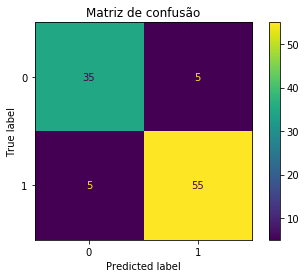

In [15]:
#Matriz de confusão

MLP3.classes_ =  ["0","1"]
plot_confusion_matrix_(X, y, MLP3)

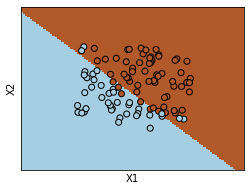

In [16]:
# Gráfico de dispersão 

plot_boundaries(X, y, MLP3)

In [17]:
# 5-fold

fold_MLP = networksMLP(hidden_layer_size=3)
k_fold(X, y, 5, fold_MLP)

Erros:  [0.9    0.9125 0.8375 0.8625 0.925 ]


### Tamanho da camada oculta = 4

In [18]:
#Acurácia

MLP4 = networksMLP(input_layer_size=2, hidden_layer_size=4)
MLP4.fit(X, y, epochs=60, learning_rate=0.01)
y_pred_MLP4 = MLP4.predict(X)

print('Acurácia: ', acuracia(y, y_pred_MLP4))

Acurácia:  0.6


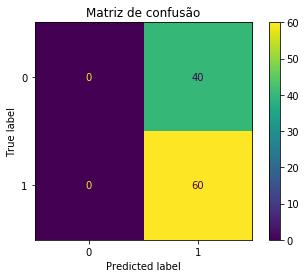

In [19]:
#Matriz de confusão

MLP4.classes_ =  ["0","1"]
plot_confusion_matrix_(X, y, MLP4)

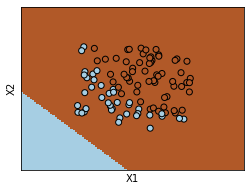

In [20]:
# Gráfico de dispersão 

plot_boundaries(X, y, MLP4)

In [21]:
# 5-fold

fold_MLP = networksMLP(hidden_layer_size=4)
k_fold(X, y, 5, fold_MLP)

Erros:  [0.6    0.7    0.675  0.7125 0.675 ]


## KNN

### Para k=1

In [22]:
#Acurácia

KNN1 = knn(k=1)
KNN1.fit(X, y)
y_pred_KNN1 = KNN1.predict(X)

print('Acurácia: ', acuracia(y, y_pred_KNN1))

Acurácia:  1.0


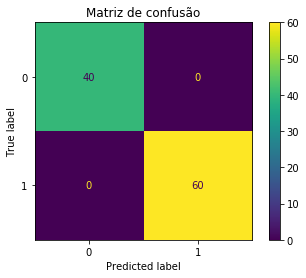

In [23]:
#Matriz de confusão

KNN1.classes_ =  ["0","1"]
plot_confusion_matrix_(X, y, KNN1)

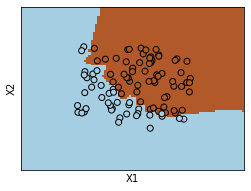

In [24]:
# Gráfico de dispersão 

plot_boundaries(X, y, KNN1)

In [25]:
# 5-fold

fold_KNN = knn(k=1)
k_fold(X, y, 5, fold_KNN)

Erros:  [0.875  0.85   0.8    0.8375 0.8375]


### Para k=2

In [26]:
#Acurácia

KNN2 = knn(k=2)
KNN2.fit(X, y)
y_pred_KNN2 = KNN2.predict(X)

print('Acurácia: ', acuracia(y, y_pred_KNN2))

Acurácia:  0.94


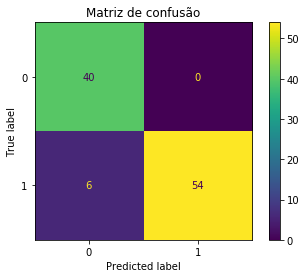

In [27]:
#Matriz de confusão

KNN2.classes_ =  ["0","1"]
plot_confusion_matrix_(X, y, KNN2)

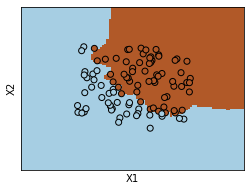

In [28]:
# Gráfico de dispersão 

plot_boundaries(X, y, KNN2)

In [29]:
# 5-fold

fold_KNN = knn(k=2)
k_fold(X, y, 5, fold_KNN)

Erros:  [0.8375 0.825  0.8    0.7625 0.8875]


### Para k=3

In [30]:
#Acurácia

KNN3 = knn(k=3)
KNN3.fit(X, y)
y_pred_KNN3 = KNN3.predict(X)

print('Acurácia: ', acuracia(y, y_pred_KNN3))

Acurácia:  0.95


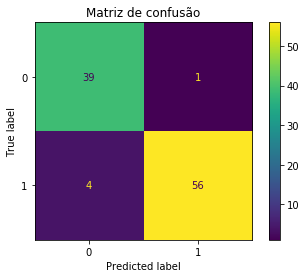

In [31]:
#Matriz de confusão

KNN3.classes_ =  ["0","1"]
plot_confusion_matrix_(X, y, KNN3)

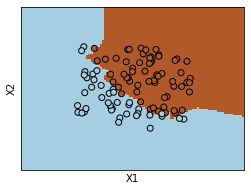

In [32]:
# Gráfico de dispersão 

plot_boundaries(X, y, KNN3)

In [33]:
# 5-fold

fold_KNN = knn(k=3)
k_fold(X, y, 5, fold_KNN)

Erros:  [0.825  0.9    0.8875 0.7875 0.7625]
